<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

### 파이토치로 훈련시키기

주요 내용

- 데이터셋 -> 모델 -> 훈련 -> 확인/사용

- Numpy Array vs Pytorch Tensor

- Forward / backward propagation

- Chain rule

- Tensor shape 출력해보기

- [Autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

가시화 도구

- [TorchViz](https://graphviz.org/download/) 윈도우 기준 graphviz-12.2.1 (64-bit) EXE installer [sha256], 경로 설정 주의, dot -V로 확인

- [Netron](https://github.com/lutzroeder/Netron)

- [Tensorboard](https://www.tensorflow.org/tensorboard)

파이썬 연습이 더 필요하다고 느끼신다면 [홍정모의 파이썬 프로그래밍 추월코스](https://www.honglab.ai/courses/python)

In [1]:
import torch

print(torch.cuda.is_available())

# if torch.cuda.is_available():
#    tensor = tensor.to("cuda")

False


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

import torchviz


In [3]:
# Define a custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.n_samples = x_data.shape[0] # Number of samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

In [4]:
x_numpy = np.array([-1.5, -0.8, 0.1, 0.9, 1.7], dtype=np.float32)
y_numpy = np.array([0.3, -0.3, 0.5, 1.8, 1.5], dtype=np.float32)

# Convert NumPy arrays to PyTorch tensors
x_input_tensor = torch.from_numpy(x_numpy).unsqueeze(1) # Add a dimension for features (N, 1)
y_target_tensor = torch.from_numpy(y_numpy).unsqueeze(1) # Add a dimension for features (N, 1)

dataset = RegressionDataset(x_input_tensor, y_target_tensor)

batch_size = len(dataset) # Use full batch size for the dataset
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False) # shuffle=False as order doesn't matter for full batch

$$\hat{y}_i = w \cdot x_i + b$$
$$\mathcal{L}= \frac{1}{n} \sum^n_{i=1} (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum^n_{i=1}(y_i - wx_i - b)^2 $$

$$  \frac{\partial \mathcal{L}}{\partial w} = \sum^n_{i=1} \left( \frac{\partial \mathcal{L}}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial w} \right) = \sum^n_{i=1} \left( \frac{\partial \mathcal{L}}{\partial \hat{y}_i} \cdot x_i \right) $$

$$  \frac{\partial \mathcal{L}}{\partial b} = \sum^n_{i=1} \left( \frac{\partial \mathcal{L}}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial b} \right) = \sum^n_{i=1} \left( \frac{\partial \mathcal{L}}{\partial \hat{y}_i} \cdot 1 \right) $$

In [5]:
# class SimpleModel(nn.Module):
#     def __init__(self, initial_weight=-10.0, initial_bias=10.0):
#         super().__init__()

#         # Trainable parameters (weights)
#         self.weight = nn.Parameter(torch.tensor([initial_weight], dtype=torch.float32))
#         self.bias = nn.Parameter(torch.tensor([initial_bias], dtype=torch.float32))

#     def forward(self, x):
#         out = self.weight * x + self.bias
#         return out

class SimpleModel(nn.Module):
    def __init__(self, initial_weight=-10.0, initial_bias=10.0):
        super().__init__()

        self.linear = nn.Linear(in_features=1, out_features=1, bias=True)

        with torch.no_grad(): # Disable gradient calculation during initialization
            self.linear.weight.fill_(initial_weight)
            self.linear.bias.fill_(initial_bias)

    def forward(self, x):
        out = self.linear(x)
        return out

model = SimpleModel(initial_weight=-10.0, initial_bias=10.0)

In [6]:
criterion = nn.MSELoss() # Mean Squared Error Loss

# Pass the model's parameters (self.weight and self.bias) to the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1) # 여기서는 Gradient Descent와 동일

num_epochs = 50

# --- Store Loss for Plotting ---
losses = []

# --- Training Loop ---
for epoch in range(num_epochs):
    # Iterate over the dataloader. Since batch_size = len(dataset), this loop runs only once per epoch.
    for x_inputs, y_targets in dataloader:
        # inputs and targets are the tensors yielded by the dataloader (our entire dataset in this case)
        # inputs shape: (N, 1), targets shape: (N, 1)

        # print(x_inputs.shape, y_targets.shape) # Check the shape of inputs and targets

        # Forward pass: compute predicted y by passing inputs to the model
        y_pred = model(x_inputs) # y_pred shape: (N, 1)

        # Compute loss
        loss = criterion(y_pred, y_targets) # loss is a scalar tensor

        # Store loss for plotting
        losses.append(loss.item()) # .item() gets the scalar value of the loss tensor

        # Zero gradients, perform a backward pass, and update the parameters
        optimizer.zero_grad() # Clear previous gradients of model.parameters()
        
        loss.backward()       # Compute gradients of the loss with respect to all parameters that require grad (self.weight, self.bias)

        optimizer.step()      # Perform a single optimization step (update self.weight and self.bias)

        if epoch == 0:
             # Visualizes the graph starting from the 'loss' tensor.
             # 'params' helps in labeling the nodes with parameter names.
             graph = torchviz.make_dot(loss, params=dict(model.named_parameters()))
             graph.render("autograd_graph", view=False) # Renders and optionally opens the graph file

    # Print loss every 10 epochs (or every epoch for detailed view)
    if (epoch + 1) % 10 == 0:
        # Access weights and bias directly from the model instance
        #print(f"Epoch {epoch + 1}: w = {model.weight.item():.4f}, b = {model.bias.item():.4f}, Loss = {loss.item():.4f}")
        print(f"Epoch {epoch + 1}: w = {model.linear.weight.item():.4f}, b = {model.linear.bias.item():.4f}, Loss = {loss.item():.4f}")
        


Epoch 10: w = -0.0835, b = 1.8877, Loss = 3.0419
Epoch 20: w = 0.5153, b = 0.8525, Loss = 0.2208
Epoch 30: w = 0.5598, b = 0.7306, Loss = 0.1886
Epoch 40: w = 0.5638, b = 0.7166, Loss = 0.1882
Epoch 50: w = 0.5642, b = 0.7151, Loss = 0.1882


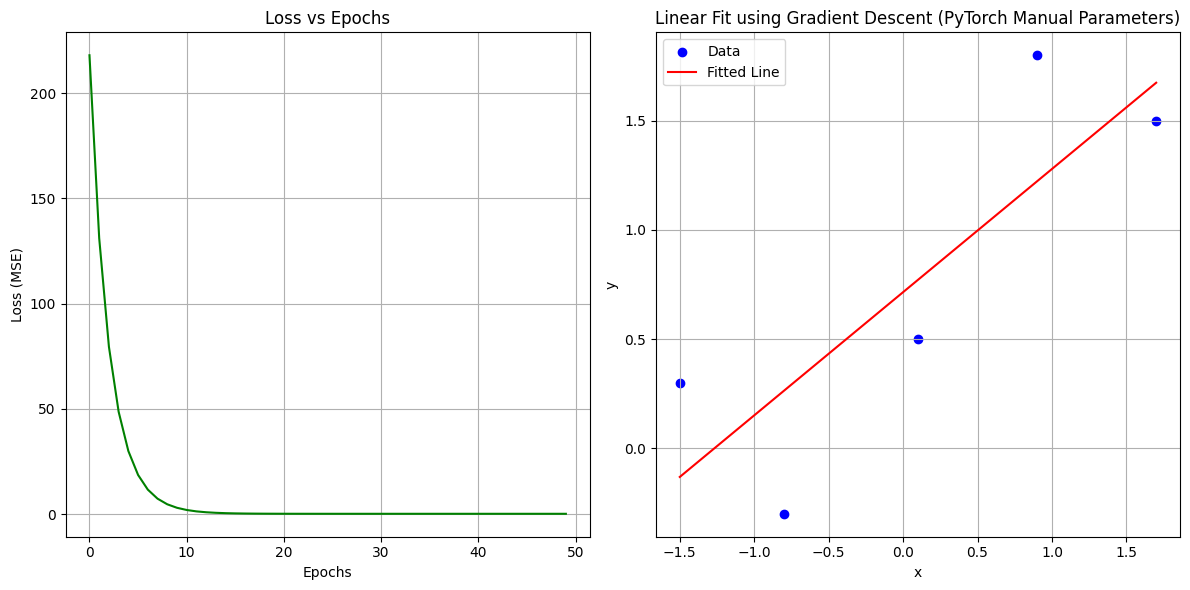

In [7]:
# --- Plot Loss Graph ---
plt.figure(figsize=(12, 6))

# Plot 1: Loss graph over epochs
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses, color='green', label='Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(True)

# --- Plot Line Graph ---
# Plot 2: Data points and fitted line
plt.subplot(1, 2, 2)
plt.scatter(x_input_tensor.numpy().squeeze(), y_target_tensor.numpy().squeeze(), color='blue', label='Data') # Use the original tensors (converted to numpy for plotting)
x_line = torch.linspace(min(x_input_tensor).item(), max(x_input_tensor).item(), 100).unsqueeze(1) # Shape (100, 1)
y_line = model(x_line).detach().numpy() # Get predictions from the trained model, detach from graph, and convert to NumPy. y_line shape: (100, 1)
plt.plot(x_line.numpy().squeeze(), y_line.squeeze(), color='red', label='Fitted Line') # Convert tensors back to NumPy for plotting and remove singleton dimensions
plt.title("Linear Fit using Gradient Descent (PyTorch Manual Parameters)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

훈련이 끝난 모델 파일 쓰기/읽기

In [8]:
torch.save(model.state_dict(), "my_model.pth")

model.load_state_dict(torch.load("my_model.pth"))

<All keys matched successfully>

훈련이 끝난 모델로 테스트

In [9]:
model.eval() # model.train() is default, but we set it to eval() for inference

with torch.no_grad():
    test_input = torch.tensor([0.5, 1.0], dtype=torch.float32).unsqueeze(1)
    test_output = model(test_input)
    print("Input", test_input.numpy())
    print("Output", test_output.numpy())

Input [[0.5]
 [1. ]]
Output [[0.9971621]
 [1.279263 ]]


### 이어지는 내용들

- 뉴럴네트워크 만들기
- 더 큰 데이터셋 - Train/Test/Val, SGD batch training
- 분류(Classification) 예제